In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import Dropout, Dense, Flatten, Activation
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.applications.efficientnet_v2 import EfficientNetV2M
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# !unzip '/content/drive/MyDrive/DatasetRoboflow/baru.zip'

In [4]:
base_dir = '/content/drive/MyDrive/updateddataset'

In [5]:
#Eksplor the dataset
import os
for dirpath, dirnames, filenames in os.walk(base_dir):
  print(f'Ada {len(dirnames)} directori dan {len(filenames)} gambar dalam {dirpath}')

Ada 3 directori dan 0 gambar dalam /content/drive/MyDrive/updateddataset
Ada 3 directori dan 0 gambar dalam /content/drive/MyDrive/updateddataset/test
Ada 0 directori dan 57 gambar dalam /content/drive/MyDrive/updateddataset/test/beef
Ada 0 directori dan 61 gambar dalam /content/drive/MyDrive/updateddataset/test/pork
Ada 0 directori dan 60 gambar dalam /content/drive/MyDrive/updateddataset/test/others
Ada 3 directori dan 0 gambar dalam /content/drive/MyDrive/updateddataset/train
Ada 0 directori dan 1356 gambar dalam /content/drive/MyDrive/updateddataset/train/beef
Ada 0 directori dan 1104 gambar dalam /content/drive/MyDrive/updateddataset/train/pork
Ada 0 directori dan 1272 gambar dalam /content/drive/MyDrive/updateddataset/train/others
Ada 3 directori dan 0 gambar dalam /content/drive/MyDrive/updateddataset/valid
Ada 0 directori dan 145 gambar dalam /content/drive/MyDrive/updateddataset/valid/beef
Ada 0 directori dan 122 gambar dalam /content/drive/MyDrive/updateddataset/valid/pork
Ad

In [6]:
#define batch size and set size of images
batch_size = 32
image_size = (224, 224)

#path of dataset
train_dir = os.path.join(base_dir +'/train')
valid_dir = os.path.join(base_dir +'/valid')
test_dir = os.path.join(base_dir +'/test')

#image generator
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=batch_size,
                                                            image_size=image_size)

valid_dataset = tf.keras.utils.image_dataset_from_directory(valid_dir,
                                                            shuffle=True,
                                                            batch_size=batch_size,
                                                            image_size=image_size)

test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                            shuffle=True,
                                                            batch_size=batch_size,
                                                            image_size=image_size)

Found 3732 files belonging to 3 classes.
Found 389 files belonging to 3 classes.
Found 178 files belonging to 3 classes.


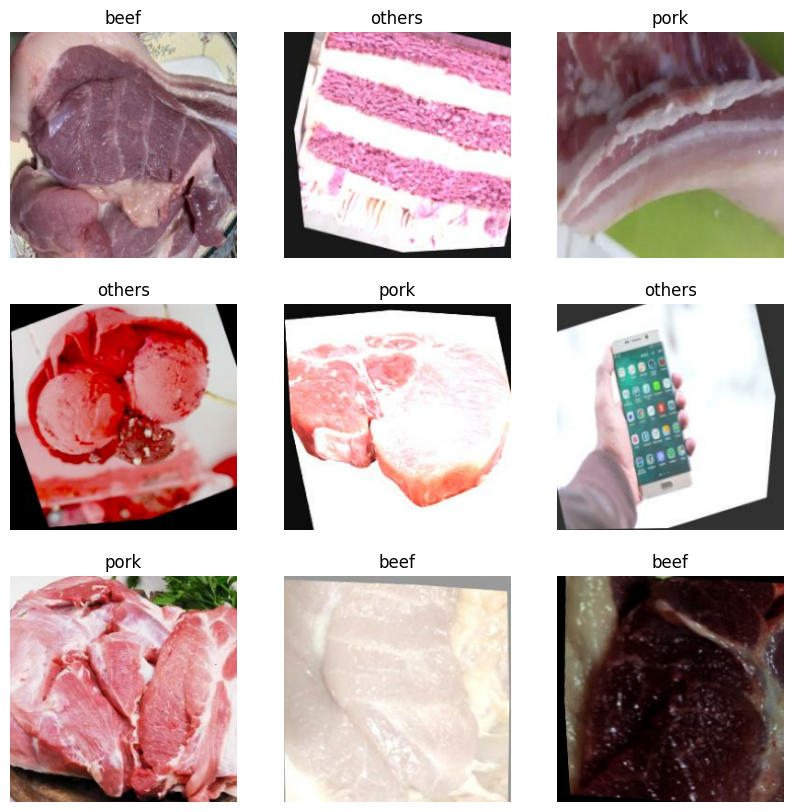

In [7]:
#show train images samples

class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
#Optimising input pipeline performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
valid_dataset = valid_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [9]:
# preprocess input images before feeding them into the MobileNetV2 mode
prep_input = tf.keras.applications.mobilenet_v2.preprocess_input
# rescale the image values
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)
image_shape = image_size + (3,) #represents the number of color channels (RGB) in the image.

#create base model using MobileNetV2, activation softmax
base_model = tf.keras.applications.MobileNetV3Large(input_shape=image_shape,
                                                    include_top=False,
                                                    weights='imagenet',
                                                    classes=3,
                                                    classifier_activation="softmax")

12683000/12683000 [==============================] - 1s 0us/step


In [10]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 960)


In [11]:
base_model.trainable = False
base_model.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling_1[0][0]']            
                                )                                                                 
                                                                                   

In [12]:
#add
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 960)


In [13]:
from keras.layers import BatchNormalization
from keras import Model

inputs = base_model.input
#inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu', name='new_layer_1')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu', name = 'new_layer_2')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu', name = 'new_layer_3')(x)

prediction_layer = Dense(3, activation='softmax', name = 'predictions')(x)

outputs = prediction_layer
model = tf.keras.Model(inputs, outputs)

In [14]:
#Compile the model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling_1[0][0]']            
                                )                                                                 
                                                                                              

In [15]:
#Evaluate the model
initial_epochs = 15
loss0, accuracy0 = model.evaluate(valid_dataset)

13/13 [==============================] - 154s 3s/step - loss: 1.6386 - accuracy: 0.2982


In [16]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.64
initial accuracy: 0.30


In [17]:
#Train the model
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=valid_dataset)

Epoch 1/15
117/117 [==============================] - 639s 5s/step - loss: 0.4030 - accuracy: 0.8486 - val_loss: 0.0670 - val_accuracy: 0.9820
Epoch 2/15
117/117 [==============================] - 11s 90ms/step - loss: 0.1027 - accuracy: 0.9775 - val_loss: 0.0430 - val_accuracy: 0.9923
Epoch 3/15
117/117 [==============================] - 11s 89ms/step - loss: 0.0488 - accuracy: 0.9941 - val_loss: 0.0424 - val_accuracy: 0.9820
Epoch 4/15
117/117 [==============================] - 11s 88ms/step - loss: 0.0259 - accuracy: 0.9962 - val_loss: 0.0425 - val_accuracy: 0.9871
Epoch 5/15
117/117 [==============================] - 10s 79ms/step - loss: 0.0182 - accuracy: 0.9984 - val_loss: 0.0371 - val_accuracy: 0.9897
Epoch 6/15
117/117 [==============================] - 11s 84ms/step - loss: 0.0118 - accuracy: 0.9992 - val_loss: 0.0346 - val_accuracy: 0.9897
Epoch 7/15
117/117 [==============================] - 11s 89ms/step - loss: 0.0076 - accuracy: 0.9992 - val_loss: 0.0533 - val_accuracy: 

In [18]:
#model_path = '/content/drive/MyDrive/befork.h5'
model.save('/content/drive/MyDrive/Export Model/beforkV3large1.h5')

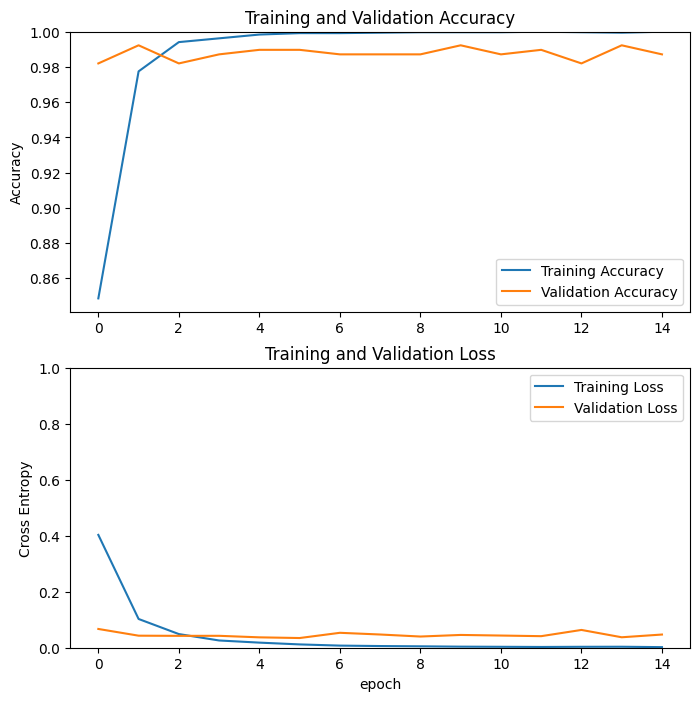

In [19]:
#plot the training result
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Add Fine Tuning For Model

In [20]:
base_model.trainable = True

ft_at = 80
#freeze the layers before 100 layer
for layer in base_model.layers[:-1]:
  layer.trainable = False

In [21]:
# compile the model
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling_1[0][0]']            
                                )                                                                 
                                                                                              

In [23]:
#Re train model after use fine tune
new_epochs = 10
total =  initial_epochs + new_epochs
hist_fine = model.fit(train_dataset,
                         epochs=total,
                         initial_epoch=history.epoch[-1],
                         validation_data=valid_dataset)

Epoch 15/25
117/117 [==============================] - 20s 117ms/step - loss: 0.0023 - accuracy: 0.9997 - val_loss: 0.0496 - val_accuracy: 0.9871
Epoch 16/25
117/117 [==============================] - 11s 88ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0497 - val_accuracy: 0.9897
Epoch 17/25
117/117 [==============================] - 11s 90ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0485 - val_accuracy: 0.9871
Epoch 18/25
117/117 [==============================] - 9s 78ms/step - loss: 0.0015 - accuracy: 0.9997 - val_loss: 0.0481 - val_accuracy: 0.9871
Epoch 19/25
117/117 [==============================] - 11s 87ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0482 - val_accuracy: 0.9871
Epoch 20/25
117/117 [==============================] - 11s 90ms/step - loss: 0.0019 - accuracy: 0.9995 - val_loss: 0.0477 - val_accuracy: 0.9897
Epoch 21/25
117/117 [==============================] - 11s 92ms/step - loss: 0.0017 - accuracy: 0.9995 - val_loss: 0.0442 - val_ac

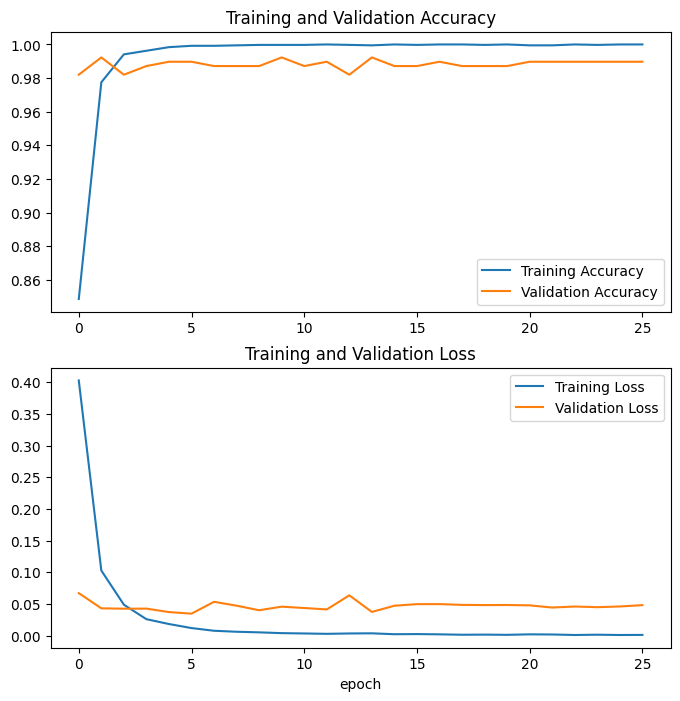

In [24]:
#Let see training result plot after add finetunning
acc += hist_fine.history['accuracy']
val_acc += hist_fine.history['val_accuracy']

loss += hist_fine.history['loss']
val_loss += hist_fine.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [25]:
#evaluate the model after finetunning
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 69s 171ms/step - loss: 0.0091 - accuracy: 1.0000
Test accuracy : 1.0


In [26]:
y_preds = []
y_true = []

for image_batch, label_batch in test_dataset:
    y_true.append(label_batch)
    pred = model.predict(image_batch)
    y_preds.append(np.argmax(pred, axis = -1))

correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_preds], axis = 0)

1/1 [==============================] - 1s 1s/step


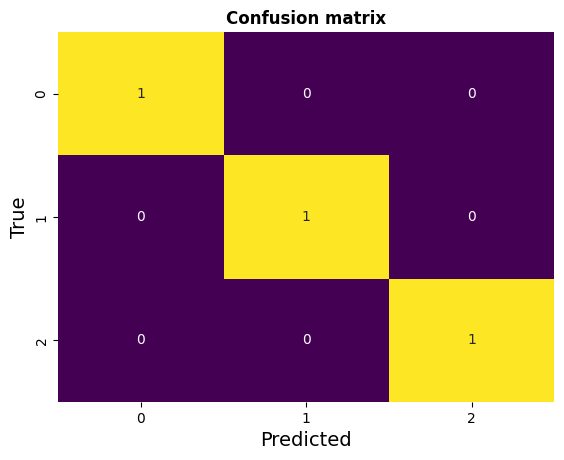

In [27]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(correct_labels, predicted_labels, normalize='true')
sns.heatmap(cm, annot=True, cmap='viridis', cbar=None)
plt.title("Confusion matrix", fontweight='bold')
plt.ylabel("True", fontsize=14)
plt.xlabel("Predicted", fontsize=14)
plt.show()

Predicted Labels:
 [1 2 0 0 0 2 2 2 1 2 1 2 2 1 0 2 1 0 2 2 0 1 0 1 2 1 0 2 2 1 2 1]
Probabilities:
 [0.9999827  0.9999318  0.99997437 0.99999356 0.99998975 0.9668924
 0.99999464 0.9980478  0.99993765 0.99996126 0.99998593 0.99999774
 0.99992216 0.9999976  0.99994206 0.99998915 0.9997366  0.99990666
 0.99523205 0.9990243  0.9999739  0.99999964 0.9999801  0.99999905
 0.9999907  0.99999905 0.9999256  0.9986632  0.9999968  0.9999913
 0.9999918  1.        ]
True Labels:
 [1 2 0 0 0 2 2 2 1 2 1 2 2 1 0 2 1 0 2 2 0 1 0 1 2 1 0 2 2 1 2 1]


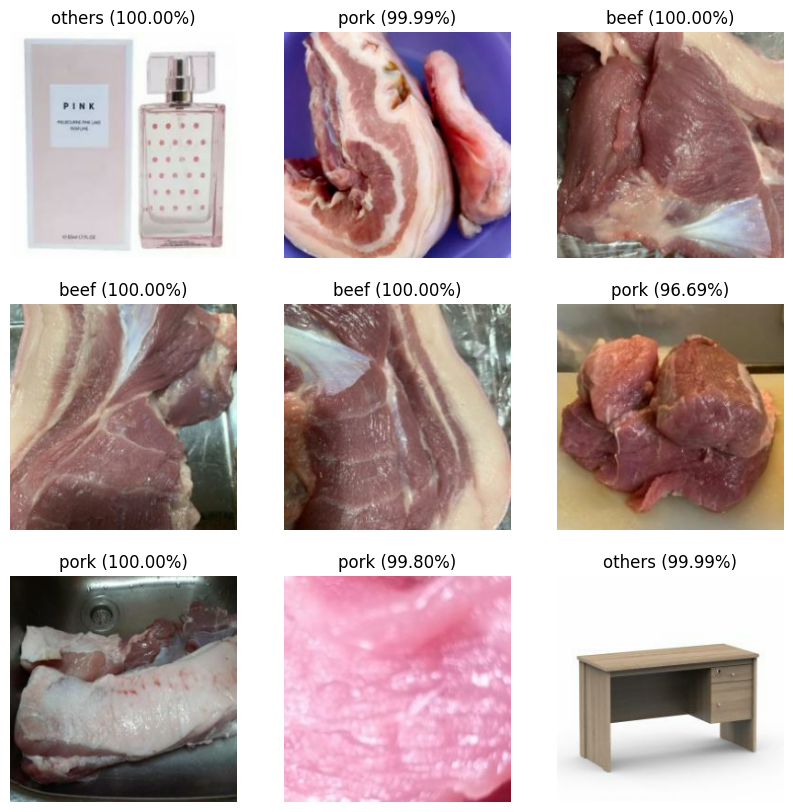

In [31]:
#Let test final model
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

# Apply softmax activation
# predictions = tf.nn.softmax(predictions)

# Get the predicted class labels
predicted_labels = tf.argmax(predictions, axis=1)

# Get the probabilities for the predicted classes
probabilities = tf.reduce_max(predictions, axis=1)

print('Predicted Labels:\n', predicted_labels.numpy())
print('Probabilities:\n', probabilities.numpy())
print('True Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title("{} ({:.2f}%)".format(class_names[predicted_labels[i]], probabilities[i] * 100))
    plt.axis("off")


In [29]:
model.save('lastmodelbefork.h5')

In [34]:
#Let Test using exported model HDF5
import tensorflow as tf
from PIL import Image
import numpy as np

def classify(model, image_path):
    image = Image.open(image_path)
    image = image.resize((224, 224))
    #image = np.array(image) / 255.0  # Normalize image

    image = np.expand_dims(image, axis=0)

    predictions = model.predict(image)
    predicted_label = np.argmax(predictions, axis=1)[0]
    probabilities = tf.reduce_max(predictions, axis=1)

    class_names = ['beef','others', 'pork']
    predicted_class = class_names[predicted_label]

    print('Predicted Class:', predicted_class)
    print('Probabilities:\n', probabilities.numpy())

# Assuming you have already loaded and compiled your TensorFlow model
model = tf.keras.models.load_model('lastmodelbefork.h5')

# Example usage
# image_path = '/content/drive/MyDrive/updateddataset/test/others/1286690_jpg.rf.c735840b6d4d18b6b3d08a6e6fb6a1a3.jpg' #others
image_path = "/content/drive/MyDrive/updateddataset/test/pork/30938455-two-pieces-of-raw-meat-pork-steak-closeup-isolated-on-white-background_jpg.rf.bad1e6e5f5efd86ce6041e0859bd3478.jpg" #pork
# image_path = "/content/drive/MyDrive/updateddataset/test/beef/FRESH-10-_JPG_jpg.rf.9b20f06d4a6329ea5f7fb60717d4009b.jpg" #beef
classify(model, image_path)




1/1 [==============================] - 1s 1s/step
Predicted Class: pork
Probabilities:
 [0.9999982]
